# Amazon Fine Food Reviews - Building a Co-review graph

In this lab, our general goal is to conduct some exploratory analysis of a medium - large dataset, namely, Amazon Fine Food Reviews, available from a [Kaggle Competition](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews).

Our general goals are the following:

- Retrieve the dataset and upload it onto Colab;
- Build the associated Co-review graph.

## Retrieving the dataset
To retrieve this dataset, we need to be registered Kaggle users. Assuming this is the case, we basically have two options:

1. Download the dataset locally. This can be useful if you want to keep a copy of the data to work with directly on your machine. In this case, you will have to upload the data on Colab in order to work with it. There are several ways to do this, described [here](https://colab.research.google.com/notebooks/io.ipynb). Note that our compressed dataset is about 300MB's and proceeding this way may take some time, depending on your connection.
2. Transferring the data directly from Kaggle to Google. In my experience, this was extremely fast and it is the method I am going to use.

A nice review of all available methods, including the one I am using, can be found [here](https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7).

### Transferring dataset from Google to Colab
Go to your profile on Kaggle, then ```Account --> Create New API Token``` (you do not have to do every time you run your notebook). The result will be a file called ```kaggle.json```, which you save on your machine. Next, we upload this file to Google Colab as follows:

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


We next specify the above directory as the one to upload the Kaggle dataset to:

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Next, we need to upload the dataset, issuing the necessary shell command. To do this, we can let Kaggle generate the right command for us. This is done from the Kaggle competion's Web page, in the top-right menu, clicking on the dots and then selecting ```Copy API Command``` as shown in the picture below:

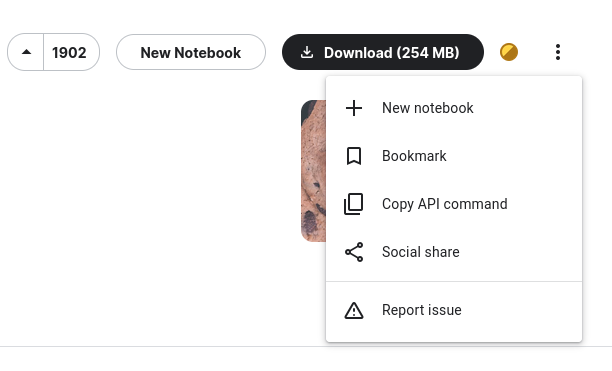

The copy-pasted command is the one shown below:

In [4]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 95% 229M/242M [00:01<00:00, 227MB/s]
100% 242M/242M [00:01<00:00, 221MB/s]


In [5]:
!chmod 600 /content/kaggle.json

We next check that everything is there:

In [6]:
!ls

amazon-fine-food-reviews.zip  kaggle.json  sample_data


In [7]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=1e047de216fac2f3b021b06978dbef03384b62c9014dc31579701b2dc4facbc7
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


We now extract the files from the zipper archive. To this purpose, we use Python zipfile utility package:

In [48]:
# import libraries
from zipfile import ZipFile
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size, desc, collect_list, array_intersect, array, struct
from google.colab import files

In [9]:
# Create a ZipFile Object and load sample.zip in it
with ZipFile('amazon-fine-food-reviews.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Let's check what files are there (we are looking for ```Reviews.csv```)

In [10]:
!ls

amazon-fine-food-reviews.zip  database.sqlite  hashes.txt  kaggle.json	Reviews.csv  sample_data


There it is. Let us just perform a check that the file looks like it is supposed to be, by having a glance at the first 10 lines:

In [11]:
!head -10 Reviews.csv

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally co

Keeping roughly $10\%$ of the users for testing purposes. We will see why doing this is reasonable further in the course. For now, try to understand how ```sample_users``` works and why it does the job.

In [33]:
# Create a Spark session
spark = SparkSession.builder.appName("CoReviewGraph").getOrCreate()
#Load into a pandas df
data_path = "Reviews.csv"
df = pd.read_csv(data_path)

In [13]:
# Given a Pandas frame raw_pd, save lines corresponding to approximately 10% of the users to file fout
# Note that all lines corresponding to sampled users are saved to fout

def sample_users(raw_pd, rate, buckets, fout):
  fout.write("\t".join(map(str, raw_pd.columns)) + "\n")
  for index, row in raw_pd.iterrows():
    if (hash(row["UserId"])%buckets < rate):
      # Save this line to fout
      #Create a tsv
      fout.write('\t'.join(map(str, row)) + '\n')


sampled_file = "Reviews_sampled.csv"
rate = 10 # 10% of users
buckets = 100

fout = open(sampled_file, "w")
sample_users(df, rate, buckets, fout)
fout.close()

In [83]:
# Run it with data_path if you want to run the entire dataframe otherwise uncomment this line for a sample dataframe
#dfff = spark.read.csv(sampled_file, sep="\t", header=True)
dfff = spark.read.csv(data_path, sep=",", header=True)

#take only the columns of UserId and ProductId because are the columns we are intrested in
user_product = dfff.select("UserId", "ProductId")
user_product.show()

+--------------+----------+
|        UserId| ProductId|
+--------------+----------+
|A3SGXH7AUHU8GW|B001E4KFG0|
|A1D87F6ZCVE5NK|B00813GRG4|
| ABXLMWJIXXAIN|B000LQOCH0|
|A395BORC6FGVXV|B000UA0QIQ|
|A1UQRSCLF8GW1T|B006K2ZZ7K|
| ADT0SRK1MGOEU|B006K2ZZ7K|
|A1SP2KVKFXXRU1|B006K2ZZ7K|
|A3JRGQVEQN31IQ|B006K2ZZ7K|
|A1MZYO9TZK0BBI|B000E7L2R4|
|A21BT40VZCCYT4|B00171APVA|
|A3HDKO7OW0QNK4|B0001PB9FE|
|A2725IB4YY9JEB|B0009XLVG0|
| A327PCT23YH90|B0009XLVG0|
|A18ECVX2RJ7HUE|B001GVISJM|
|A2MUGFV2TDQ47K|B001GVISJM|
|A1CZX3CP8IKQIJ|B001GVISJM|
|A3KLWF6WQ5BNYO|B001GVISJM|
| AFKW14U97Z6QO|B001GVISJM|
|A2A9X58G2GTBLP|B001GVISJM|
|A3IV7CL2C13K2U|B001GVISJM|
+--------------+----------+
only showing top 20 rows



In [84]:
# Group by user and collect the products they reviewed so that i can count the product reviewed by a user
grouped_df = user_product.groupBy("UserId", "ProductId").count()
grouped_df.show()

+--------------+----------+-----+
|        UserId| ProductId|count|
+--------------+----------+-----+
| ARYVQL4N737A1|B001GVISJM|    1|
| ADL44P8Z4A3M5|B000ITVLE2|    1|
|A2DN52HYY0X7XM|B000S806VM|    1|
|A2GTW6FM6DRZSZ|B000I5DJVE|    1|
|A1UB23942QQ7WP|B001RVFDOO|    1|
|A2XUYFBCXRO21E|B001E5E29A|    1|
| ALSYGPNMPPQ9U|B000LKTDNE|    1|
|A37GT5BCO92X1X|B000EPP56K|    1|
|A380XR46YNMY4G|B0007T3V82|    1|
|A3N7T3Q56NR6UG|B0089SPDUW|    1|
|A2ZVJRZYAQ1T2V|B000ED9LDU|    1|
|A1BZZWKT8B5643|B000F9Z1WI|    1|
|A2MWRKME57F53V|B0005YYHQY|    1|
|A3U78OW4OO2Q8W|B000B9SFP2|    1|
| A4EWLZLUCY5QR|B003OZYUEA|    1|
|A2A4HGFGKO6BKP|B005K4Q1VI|    1|
|A1Z54EM24Y40LL|B004X8TK9W|    1|
|A1CUJQ3Q14G0OV|B000FDKQC4|    1|
|A37WRS6GFVU478|B0045IK1CK|    1|
|A2O2HNXBRBH6K6|B004391DK0|    1|
+--------------+----------+-----+
only showing top 20 rows



In [85]:
# Create a new DataFrame with inverted columns : ProductId and UserId because i need to add this new df to the previous one to make a join in the productId
inverted_df = grouped_df.selectExpr("ProductId as ProductId2", "UserId as UserId2", "count as count2")

# Show the result
inverted_df.show()


+----------+--------------+------+
|ProductId2|       UserId2|count2|
+----------+--------------+------+
|B001GVISJM| ARYVQL4N737A1|     1|
|B000ITVLE2| ADL44P8Z4A3M5|     1|
|B000S806VM|A2DN52HYY0X7XM|     1|
|B000I5DJVE|A2GTW6FM6DRZSZ|     1|
|B001RVFDOO|A1UB23942QQ7WP|     1|
|B001E5E29A|A2XUYFBCXRO21E|     1|
|B000LKTDNE| ALSYGPNMPPQ9U|     1|
|B000EPP56K|A37GT5BCO92X1X|     1|
|B0007T3V82|A380XR46YNMY4G|     1|
|B0089SPDUW|A3N7T3Q56NR6UG|     1|
|B000ED9LDU|A2ZVJRZYAQ1T2V|     1|
|B000F9Z1WI|A1BZZWKT8B5643|     1|
|B0005YYHQY|A2MWRKME57F53V|     1|
|B000B9SFP2|A3U78OW4OO2Q8W|     1|
|B003OZYUEA| A4EWLZLUCY5QR|     1|
|B005K4Q1VI|A2A4HGFGKO6BKP|     1|
|B004X8TK9W|A1Z54EM24Y40LL|     1|
|B000FDKQC4|A1CUJQ3Q14G0OV|     1|
|B0045IK1CK|A37WRS6GFVU478|     1|
|B004391DK0|A2O2HNXBRBH6K6|     1|
+----------+--------------+------+
only showing top 20 rows



In [86]:
# Perform a join between the original and inverted DataFrames I'm not joining when the 2 dataframe have the same UserId. 
joined_df = grouped_df.join(inverted_df,(grouped_df["ProductId"] == inverted_df["ProductId2"]) & (grouped_df["UserId"] != inverted_df["UserId2"]))

# Show the result
joined_df.show()
joined_df.count()

+--------------+----------+-----+----------+--------------+------+
|        UserId| ProductId|count|ProductId2|       UserId2|count2|
+--------------+----------+-----+----------+--------------+------+
|A13RRPGE79XFFH|B00002NCJC|    1|B00002NCJC|A196AJHU9EASJN|     1|
|A196AJHU9EASJN|B00002NCJC|    1|B00002NCJC|A13RRPGE79XFFH|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84|A1FJOY14X3MUHE|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84|A2AGGA5NG8Q6A4|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84|A2XAKGRUHIE2ZA|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84|A1G3SYHKCFNYLJ|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84|A2MPA16ZVRJ896|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84|A39BNX3RKYTVE8|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84|A1XFT3DORZ3K5G|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84|A1XV6E6HR9HSZZ|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84|A370Z6I5GBWU44|     1|
|A2QMG8YITGWJE7|B00004CI84|    1|B00004CI84| ANCOMAI0I7LVG|   

53161566

In [88]:
# Perform groupBy operation on 'UserId' and 'UserId2' to count the exact numbers of reviews of each user
grouped_df_join = joined_df.groupBy("UserId","UserId2").count()
grouped_df_join.show()
#grouped_df_join.count()

+--------------+--------------+-----+
|        UserId|       UserId2|count|
+--------------+--------------+-----+
|A2MPA16ZVRJ896| AU0E2I06YSFA4|    3|
|A2MPA16ZVRJ896|A1GB1Q193DNFGR|    3|
|A39BNX3RKYTVE8|A3J0V5L5APJ61R|    3|
|A39BNX3RKYTVE8| A9S4LP09MYESM|    3|
|A1XV6E6HR9HSZZ| AZRJH4JFB59VC|    3|
| ANCOMAI0I7LVG|A2D9OASHI47H73|    3|
| AGBA7LQIR4BHX| A9FPWQFMN25K5|    3|
| AY12DBB0U420B| AD8X8DT1F6WMQ|    3|
| AY12DBB0U420B| ADIDQRLLR4KBQ|    3|
| AY12DBB0U420B| AW3FTPCBPVQNB|    3|
|A20LY8E9NGYA4M|A1NVW4NUXPOSJB|    3|
|A3PJJ7MNJNBXXO|A1E5AVR7QJN8HF|    3|
|  AEE48JKI02W5| ASCVAUPIB31OD|    3|
|A2B3Z2QHW3V35S|A20EEWWSFMZ1PN|    2|
|A3R2YB0WTTB0IJ|A2XAKGRUHIE2ZA|    3|
|A3R2YB0WTTB0IJ|A2Q5Y2EMS6KDWI|    3|
|A19JYLHD94K94D|A3K8TDFH5GOPNE|    3|
| ACJR7EQF9S6FP|A1VTP9QUHAOTXR|    3|
|A2H1WNB30JNAWU|A3R2YB0WTTB0IJ|    3|
|A21GKWZJL8BVJ7|A1MWRQCMOLQSBF|    3|
+--------------+--------------+-----+
only showing top 20 rows



In [89]:
# Group by UserId for changing the second column in this format AU0E2I06YSFA4,3 because i need to tranform it in a list after this point
result_df = grouped_df_join.withColumn("UserId2", F.concat_ws(",", grouped_df_join["UserId2"], grouped_df_join["count"])) \
    .withColumnRenamed("UserId2", "UserId2 count")
result_df.show(truncate=False)

+--------------+----------------+-----+
|UserId        |UserId2 count   |count|
+--------------+----------------+-----+
|A2MPA16ZVRJ896|AU0E2I06YSFA4,3 |3    |
|A2MPA16ZVRJ896|A1GB1Q193DNFGR,3|3    |
|A39BNX3RKYTVE8|A3J0V5L5APJ61R,3|3    |
|A39BNX3RKYTVE8|A9S4LP09MYESM,3 |3    |
|A1XV6E6HR9HSZZ|AZRJH4JFB59VC,3 |3    |
|ANCOMAI0I7LVG |A2D9OASHI47H73,3|3    |
|AGBA7LQIR4BHX |A9FPWQFMN25K5,3 |3    |
|AY12DBB0U420B |AD8X8DT1F6WMQ,3 |3    |
|AY12DBB0U420B |ADIDQRLLR4KBQ,3 |3    |
|AY12DBB0U420B |AW3FTPCBPVQNB,3 |3    |
|A20LY8E9NGYA4M|A1NVW4NUXPOSJB,3|3    |
|A3PJJ7MNJNBXXO|A1E5AVR7QJN8HF,3|3    |
|AEE48JKI02W5  |ASCVAUPIB31OD,3 |3    |
|A2B3Z2QHW3V35S|A20EEWWSFMZ1PN,2|2    |
|A3R2YB0WTTB0IJ|A2XAKGRUHIE2ZA,3|3    |
|A3R2YB0WTTB0IJ|A2Q5Y2EMS6KDWI,3|3    |
|A19JYLHD94K94D|A3K8TDFH5GOPNE,3|3    |
|ACJR7EQF9S6FP |A1VTP9QUHAOTXR,3|3    |
|A2H1WNB30JNAWU|A3R2YB0WTTB0IJ,3|3    |
|A21GKWZJL8BVJ7|A1MWRQCMOLQSBF,3|3    |
+--------------+----------------+-----+
only showing top 20 rows



In [90]:
# Cretating a list in the second column = [AU0E2I06YSFA4,3]
result_df = result_df.withColumn("UserId2 count", F.expr("split(concat_ws(',', `UserId2 count`), ',')"))

# Show the result
result_df.show(truncate=False)

+--------------+-------------------+-----+
|UserId        |UserId2 count      |count|
+--------------+-------------------+-----+
|A2MPA16ZVRJ896|[AU0E2I06YSFA4, 3] |3    |
|A2MPA16ZVRJ896|[A1GB1Q193DNFGR, 3]|3    |
|A39BNX3RKYTVE8|[A3J0V5L5APJ61R, 3]|3    |
|A39BNX3RKYTVE8|[A9S4LP09MYESM, 3] |3    |
|A1XV6E6HR9HSZZ|[AZRJH4JFB59VC, 3] |3    |
|ANCOMAI0I7LVG |[A2D9OASHI47H73, 3]|3    |
|AGBA7LQIR4BHX |[A9FPWQFMN25K5, 3] |3    |
|AY12DBB0U420B |[AD8X8DT1F6WMQ, 3] |3    |
|AY12DBB0U420B |[ADIDQRLLR4KBQ, 3] |3    |
|AY12DBB0U420B |[AW3FTPCBPVQNB, 3] |3    |
|A20LY8E9NGYA4M|[A1NVW4NUXPOSJB, 3]|3    |
|A3PJJ7MNJNBXXO|[A1E5AVR7QJN8HF, 3]|3    |
|AEE48JKI02W5  |[ASCVAUPIB31OD, 3] |3    |
|A2B3Z2QHW3V35S|[A20EEWWSFMZ1PN, 2]|2    |
|A3R2YB0WTTB0IJ|[A2XAKGRUHIE2ZA, 3]|3    |
|A3R2YB0WTTB0IJ|[A2Q5Y2EMS6KDWI, 3]|3    |
|A19JYLHD94K94D|[A3K8TDFH5GOPNE, 3]|3    |
|ACJR7EQF9S6FP |[A1VTP9QUHAOTXR, 3]|3    |
|A2H1WNB30JNAWU|[A3R2YB0WTTB0IJ, 3]|3    |
|A21GKWZJL8BVJ7|[A1MWRQCMOLQSBF, 3]|3    |
+----------

In [94]:
# This code groups the original result_df by "UserId" and creates a new column "UserId2Count" that contains a list of structs.
# Each struct represents a combination of "UserId2" and "count" for the corresponding group.
grouped_df = result_df.groupBy("UserId") \
               .agg(F.collect_list(F.expr("named_struct('UserId2', `UserId2 count`[0], 'count', `UserId2 count`[1])")).alias("UserId2Count"))
grouped_df.show(truncate=False)

+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [95]:
# This code sorts the array of structs in the "UserId2Count" column in ascending order.
sorted_df = grouped_df.withColumn("UserId2Count", F.sort_array("UserId2Count", asc=True))
#sorted_df.show(truncate=False)

In [96]:
# Convert the DataFrame to the "UserId" "UserId2Count" structure
structured_df = sorted_df.select("UserId", "UserId2Count")
# Convert the DataFrame to a list of tuples
result_list = []
# Take the first 10 rows
for row in structured_df.take(10):
    user_id = row["UserId"]

    # Sort the inner list based on the numbers of counts in the tuple (second element) in descending order
    user_id_count_list = sorted([(item["UserId2"], int(item["count"])) for item in row["UserId2Count"]],
                                key=lambda x: x[1], reverse=True)

    # Append the sorted tuple to the result_list
    result_list.append((user_id, user_id_count_list))


In [97]:
# Write the list into a file
with open("Review_output.txt", "w") as file:
    file.write("[")
    for i, item in enumerate(result_list):
        user_id, count_list = item
        formatted_count_list = ', '.join(f'("{user}", {count})' for user, count in count_list)
        file.write(f'("{user_id}", [{formatted_count_list}])')
        if i < len(result_list) - 1:
            file.write(',\n')
    file.write("]")

In [98]:
# Download the file
files.download("Review_output.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
# Stop session
spark.stop()